# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from imblearn.over_sampling import SMOTE
%matplotlib inline

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns',500)

# Loading Rating Data

In [3]:
ratings = pd.read_csv(r"rating_final.csv")

In [4]:
ratings.shape

(1161, 5)

In [5]:
ratings.userID.nunique()

138

In [6]:
ratings.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [7]:
ratings.shape

(1161, 5)

# Checking to see if the rating data has duplicate rows

In [8]:
ratings[~ratings.iloc[:,:-1].duplicated()]

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2
...,...,...,...,...,...
1156,U1043,132630,1,1,1
1157,U1011,132715,1,1,0
1158,U1068,132733,1,1,0
1159,U1068,132594,1,1,1


# Since the dimension of rating data matches with the dimension of the above data frame which proves that no duplicate ratings are there

In [9]:
n = input("Enter 1 for prediciting General Restaurant Rating, 2 for predicting Food Rating and 3 for Service Rating: ")
ratings = ratings.iloc[:,[0,1,int(n)+1]]

Enter 1 for prediciting General Resturant Rating, 2 for predicting Food Rating and 3 for Service Rating: 1


In [10]:
ratings

,userID,placeID,rating
0,U1077,135085,2
1,U1077,135038,2
2,U1077,132825,2
3,U1077,135060,1
4,U1068,135104,1
...,...,...,...
1156,U1043,132630,1
1157,U1011,132715,1
1158,U1068,132733,1
1159,U1068,132594,1


# Checking Class Distribution

In [11]:
ratings.iloc[:,-1].value_counts()

2    486
1    421
0    254
Name: rating, dtype: int64

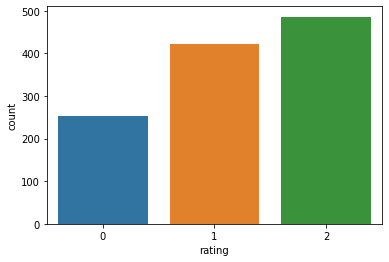

In [12]:
sns.countplot(ratings.iloc[:,-1])

# 41% of the people rated 2 , 36% rated 1 and 21% rated 0

In [13]:
ratings.iloc[:,-1].value_counts()/ratings.shape[0]

2    0.418605
1    0.362618
0    0.218777
Name: rating, dtype: float64

# Loading User Profile Data

In [14]:
user_profile = pd.read_csv(r"userprofile.csv")

In [15]:
user_profile.userID.nunique()

138

In [16]:
user_profile.shape

(138, 19)

# No duplicate data found since dimension are same for line no 9 an 10

In [17]:
user_profile.head()

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height
0,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,1989,variety,thrifty-protector,none,student,black,69,medium,1.77
1,U1002,22.150087,-100.983325,false,abstemious,informal,family,public,single,independent,1990,technology,hunter-ostentatious,Catholic,student,red,40,low,1.87
2,U1003,22.119847,-100.946527,false,social drinker,formal,family,public,single,independent,1989,none,hard-worker,Catholic,student,blue,60,low,1.69
3,U1004,18.867000,-99.183000,false,abstemious,informal,family,public,single,independent,1940,variety,hard-worker,none,professional,green,44,medium,1.53
4,U1005,22.183477,-100.959891,false,abstemious,no preference,family,public,single,independent,1992,none,thrifty-protector,Catholic,student,black,65,medium,1.69


# Checking to see the cardinality of the Categorical Variables in the user profile data

In [18]:
user_profile.describe(include=['O'])

,userID,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,interest,personality,religion,activity,color,budget
count,138,138,138,138,138,138,138,138,138,138,138,138,138,138
unique,138,3,3,5,4,4,4,4,5,4,5,5,8,4
top,U1059,false,abstemious,no preference,family,public,single,independent,variety,hard-worker,Catholic,student,blue,medium
freq,1,109,51,53,70,82,122,113,50,61,99,113,45,91


In [19]:
user_profile.smoker.value_counts()

false    109
true      26
?          3
Name: smoker, dtype: int64

In [20]:
user_profile.dress_preference.value_counts()

no preference    53
formal           41
informal         35
?                 5
elegant           4
Name: dress_preference, dtype: int64

In [21]:
user_profile.ambience.value_counts()

family      70
friends     46
solitary    16
?            6
Name: ambience, dtype: int64

In [22]:
user_profile.transport.value_counts()

public       82
car owner    35
on foot      14
?             7
Name: transport, dtype: int64

In [23]:
user_profile.marital_status.value_counts()

single     122
married     10
?            4
widow        2
Name: marital_status, dtype: int64

In [24]:
user_profile.activity.value_counts()

student          113
professional      15
?                  7
unemployed         2
working-class      1
Name: activity, dtype: int64

In [25]:
user_profile.budget.value_counts()

medium    91
low       35
?          7
high       5
Name: budget, dtype: int64

# Since for 3 users, there is no data for smoking habits, it is safe to impute it with the false class as it occurs more often than true

In [26]:
user_profile.loc[user_profile.smoker == '?', 'smoker'] = 'false'

# Since for 5 users, there is no data for dress preference, it is safe to impute it with the 'no preference' class as it occurs more often than other classes

In [27]:
user_profile.loc[user_profile.dress_preference == '?', 'dress_preference'] = 'no preference'

# Since for 7 users, there is no data for transport, it is safe to impute it with the 'transport' class as it occurs more often than other classes


In [28]:
user_profile.loc[user_profile.transport == '?', 'transport'] = 'public'

# Since for 6 users, there is no data for ambience, it is safe to impute it with the 'family' class as it occurs more often than other classes

In [29]:
user_profile.loc[user_profile.ambience == '?', 'ambience'] = 'family'

# Since for 4 users, there is no data for marital, it is safe to impute it with the 'single' class as it occurs more often than other classes

In [30]:
user_profile.loc[user_profile.marital_status == '?', 'marital_status'] = 'single'

# Since for 7 users, there is no data for activity, it is safe to impute it with the 'student' class as it occurs more often than other classes

In [31]:
user_profile.loc[user_profile.activity == '?', 'activity'] = 'student'

In [32]:
# Since for 7 users, there is no data for budget, it is safe to impute it with the 'medium' class as it occurs more often than other classes

In [33]:
user_profile.loc[user_profile.budget == '?','budget'] = 'medium'

# Most of the users in the user base doesn't smoke

In [192]:
user_profile.smoker.value_counts()/user_profile.shape[0]

false    0.811594
true     0.188406
Name: smoker, dtype: float64

# Most of the users in the user base are abstemious

In [34]:
user_profile.drink_level.value_counts()/user_profile.shape[0]

abstemious        0.369565
casual drinker    0.340580
social drinker    0.289855
Name: drink_level, dtype: float64

# Most of the users in the user base has no dress preference

In [35]:
user_profile.dress_preference.value_counts()/user_profile.shape[0]

no preference    0.420290
formal           0.297101
informal         0.253623
elegant          0.028986
Name: dress_preference, dtype: float64

# Most of the users in the user base likes family ambience

In [36]:
user_profile.ambience.value_counts()/user_profile.shape[0]

family      0.550725
friends     0.333333
solitary    0.115942
Name: ambience, dtype: float64

# Most of the users in the user base uses public transport

In [37]:
user_profile.transport.value_counts()/user_profile.shape[0]

public       0.644928
car owner    0.253623
on foot      0.101449
Name: transport, dtype: float64

# Most of the users in the user base uses is single

In [38]:
user_profile.marital_status.value_counts()/user_profile.shape[0]

single     0.913043
married    0.072464
widow      0.014493
Name: marital_status, dtype: float64

# Most of the users in the user base uses is student

In [39]:
user_profile.activity.value_counts()/user_profile.shape[0]

student          0.869565
professional     0.108696
unemployed       0.014493
working-class    0.007246
Name: activity, dtype: float64

In [40]:
col = ['smoker','drink_level','dress_preference','ambience','transport','marital_status','activity']

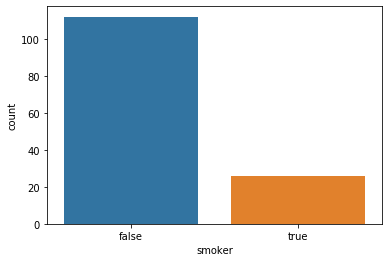

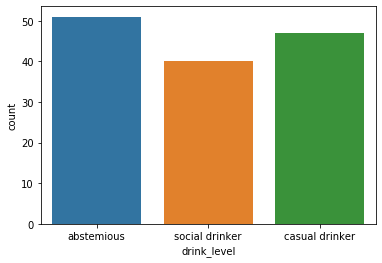

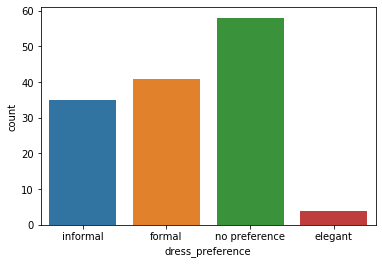

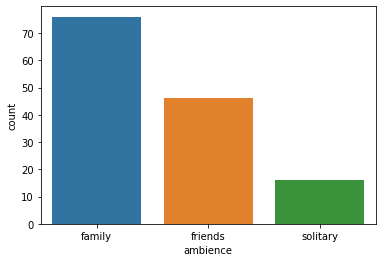

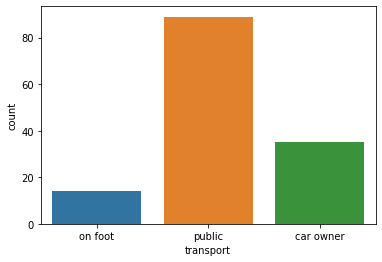

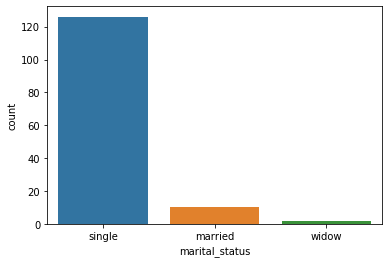

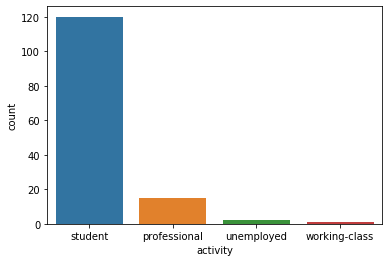

In [41]:
for i in col:
    sns.countplot(user_profile.loc[:,i])
    plt.show()

# Most of the users are in their early 30s and there seem to be a small section of user who are in their 90s

In [194]:
(2020 - user_profile.birth_year).describe()

count    138.000000
mean      35.297101
std       14.655364
min       26.000000
25%       29.000000
50%       31.000000
75%       33.000000
max       90.000000
Name: birth_year, dtype: float64

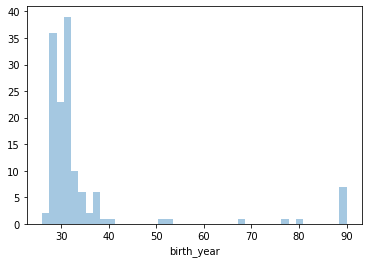

In [42]:
sns.distplot(2020 - user_profile.birth_year, kde = False)

# Most of the users are 1.7 m in height

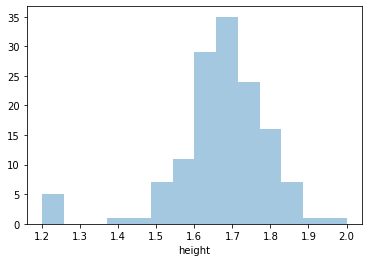

In [187]:
sns.distplot(user_profile.height, kde = False)

# Most the users lie in the 60 - 70 kg bin

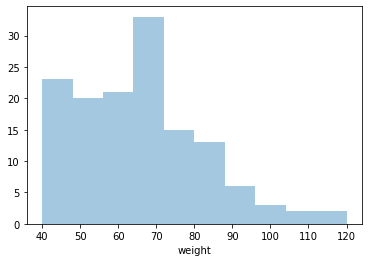

In [188]:
sns.distplot(user_profile.weight, kde = False)

# Loading user payment data

In [43]:
user_payments = pd.read_csv(r"userpayment.csv")

In [44]:
user_payments.userID.nunique()

133

In [45]:
user_payments.shape

(177, 2)

# Duplicate user id entries were found

In [46]:
user_payments.head()

,userID,Upayment
0,U1001,cash
1,U1002,cash
2,U1003,cash
3,U1004,cash
4,U1004,bank_debit_cards


# Concatenating the user payment methods into a list for condensed view

In [47]:
user_payments_conc = user_payments.groupby('userID')['Upayment'].apply(list).reset_index()

In [48]:
user_payments_conc['Upayment'] = user_payments_conc.apply(lambda x: sorted(x['Upayment']), axis = 1)

# Most of the users prefer to pay cash

In [49]:
user_payments_conc.Upayment.value_counts()

[cash]                                                 98
[bank_debit_cards, cash]                               14
[VISA, cash]                                            8
[VISA, bank_debit_cards, cash]                          5
[MasterCard-Eurocard, cash]                             2
[American_Express, VISA]                                1
[American_Express, cash]                                1
[bank_debit_cards]                                      1
[MasterCard-Eurocard, VISA, cash]                       1
[American_Express, VISA, bank_debit_cards, cash]        1
[MasterCard-Eurocard, VISA, bank_debit_cards, cash]     1
Name: Upayment, dtype: int64

# Merging the user profile data with payment data

In [50]:
user_prof_pay  = pd.merge(left=user_profile, right=user_payments_conc, on='userID', how ='outer')

In [51]:
user_prof_pay.shape

(138, 20)

In [52]:
user_prof_pay.head()

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height,Upayment
0,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,1989,variety,thrifty-protector,none,student,black,69,medium,1.77,[cash]
1,U1002,22.150087,-100.983325,false,abstemious,informal,family,public,single,independent,1990,technology,hunter-ostentatious,Catholic,student,red,40,low,1.87,[cash]
2,U1003,22.119847,-100.946527,false,social drinker,formal,family,public,single,independent,1989,none,hard-worker,Catholic,student,blue,60,low,1.69,[cash]
3,U1004,18.867000,-99.183000,false,abstemious,informal,family,public,single,independent,1940,variety,hard-worker,none,professional,green,44,medium,1.53,"[bank_debit_cards, cash]"
4,U1005,22.183477,-100.959891,false,abstemious,no preference,family,public,single,independent,1992,none,thrifty-protector,Catholic,student,black,65,medium,1.69,[cash]


# Loading user cusine data

In [53]:
user_cusine = pd.read_csv(r"usercuisine.csv")

In [54]:
user_cusine.shape

(330, 2)

In [55]:
user_cusine.head()

,userID,Rcuisine
0,U1001,American
1,U1002,Mexican
2,U1003,Mexican
3,U1004,Bakery
4,U1004,Breakfast-Brunch


In [56]:
user_cusine.userID.nunique()

138

# Duplicate user id entries were found

In [57]:
user_cusine_conc = user_cusine.groupby('userID')['Rcuisine'].apply(list).reset_index()

In [58]:
user_cusine_conc['Rcuisine'] = user_cusine_conc.apply(lambda x: sorted(x['Rcuisine']), axis = 1)

# Most of the people prefer Mexican cusine

In [59]:
user_cusine_conc.Rcuisine.value_counts()

[Mexican]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [60]:
user_cusine_conc.shape

(138, 2)

# Merging user profile, payment and cusine data

In [61]:
user_prof_pay_cus  = pd.merge(left=user_prof_pay, right=user_cusine_conc, on='userID', how ='outer')

In [62]:
user_prof_pay_cus.head()

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height,Upayment,Rcuisine
0,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,1989,variety,thrifty-protector,none,student,black,69,medium,1.77,[cash],[American]
1,U1002,22.150087,-100.983325,false,abstemious,informal,family,public,single,independent,1990,technology,hunter-ostentatious,Catholic,student,red,40,low,1.87,[cash],[Mexican]
2,U1003,22.119847,-100.946527,false,social drinker,formal,family,public,single,independent,1989,none,hard-worker,Catholic,student,blue,60,low,1.69,[cash],[Mexican]
3,U1004,18.867000,-99.183000,false,abstemious,informal,family,public,single,independent,1940,variety,hard-worker,none,professional,green,44,medium,1.53,"[bank_debit_cards, cash]","[Bagels, Bakery, Breakfast-Brunch, Cafe-Coffee..."
4,U1005,22.183477,-100.959891,false,abstemious,no preference,family,public,single,independent,1992,none,thrifty-protector,Catholic,student,black,65,medium,1.69,[cash],[American]


# Loading Restaurant payment acceptance data

In [63]:
res_pay = pd.read_csv(r"chefmozaccepts.csv")

In [64]:
res_pay.head()

,placeID,Rpayment
0,135110,cash
1,135110,VISA
2,135110,MasterCard-Eurocard
3,135110,American_Express
4,135110,bank_debit_cards


In [65]:
res_pay.shape

(1314, 2)

In [66]:
res_pay.placeID.nunique()

615

# Duplicate user id entries were found

In [67]:
res_pay_conc = res_pay.groupby('placeID')['Rpayment'].apply(list).reset_index()

In [68]:
res_pay_conc['Rpayment'] = res_pay_conc.apply(lambda x: sorted(x['Rpayment']), axis = 1)

In [69]:
res_pay_conc.shape

(615, 2)

In [70]:
res_pay_conc.head()

,placeID,Rpayment
0,132002,"[American_Express, Diners_Club, MasterCard-Eur..."
1,132012,"[American_Express, Diners_Club, Visa, bank_deb..."
2,132019,"[American_Express, Diners_Club, MasterCard-Eur..."
3,132023,"[American_Express, Diners_Club, Japan_Credit_B..."
4,132024,"[American_Express, Diners_Club, Visa, bank_deb..."


# Most of the Restaurants accept cash

In [71]:
res_pay_conc.Rpayment.value_counts()

[cash]                                                                                                                      312
[MasterCard-Eurocard, VISA, cash]                                                                                            47
[American_Express, MasterCard-Eurocard, VISA, cash]                                                                          36
[American_Express, MasterCard-Eurocard, VISA, bank_debit_cards, cash]                                                        26
[MasterCard-Eurocard, VISA, bank_debit_cards, cash]                                                                          20
[bank_debit_cards, cash]                                                                                                     14
[American_Express, Diners_Club, MasterCard-Eurocard, Visa]                                                                   13
[American_Express, Diners_Club, Visa, bank_debit_cards]                                                 

# Loading Restaurant cusine data

In [72]:
res_cus = pd.read_csv(r"chefmozcuisine.csv")

In [73]:
res_cus.head()

,placeID,Rcuisine
0,135110,Spanish
1,135109,Italian
2,135107,Latin_American
3,135106,Mexican
4,135105,Fast_Food


In [74]:
res_cus.shape

(916, 2)

In [75]:
res_cus.placeID.nunique()

769

# Duplicate user id entries were found

In [76]:
res_cus_conc = res_cus.groupby('placeID')['Rcuisine'].apply(list).reset_index()

In [77]:
res_cus_conc['Rcuisine'] = res_cus_conc.apply(lambda x: sorted(x['Rcuisine']), axis = 1)

In [78]:
res_cus_conc.shape

(769, 2)

In [79]:
res_cus_conc.head()

,placeID,Rcuisine
0,132001,[Dutch-Belgian]
1,132002,[Seafood]
2,132003,[International]
3,132004,[Seafood]
4,132005,"[French, Seafood]"


# Most of the Restaurants offer Mexican cusine

In [80]:
res_cus_conc.Rcuisine.value_counts()

[Mexican]                          224
[International]                     52
[American]                          48
[Dutch-Belgian]                     41
[Greek]                             33
                                  ... 
[Organic-Healthy, Vegetarian]        1
[Turkish]                            1
[Seafood, Southwestern, Steaks]      1
[Continental-European, Italian]      1
[Cafeteria, Contemporary]            1
Name: Rcuisine, Length: 122, dtype: int64

# Loading Restaurant operating hours data

In [81]:
res_hours = pd.read_csv(r"chefmozhours4.csv")

In [82]:
res_hours.head()

,placeID,hours,days
0,135111,00:00-23:30;,Mon;Tue;Wed;Thu;Fri;
1,135111,00:00-23:30;,Sat;
2,135111,00:00-23:30;,Sun;
3,135110,08:00-19:00;,Mon;Tue;Wed;Thu;Fri;
4,135110,00:00-00:00;,Sat;


In [83]:
res_hours.shape

(2339, 3)

In [84]:
res_hours.placeID.nunique()

694

# Duplicate user id entries were found

In [85]:
 res_hours_days = res_hours.groupby('placeID')['days'].apply(lambda x: ''.join(x.str.replace(';',','))).reset_index()

In [191]:
res_hours_days.head()

,placeID,days,open_all_days
0,132012,"Sun,Sun,Mon,Tue,Wed,Thu,Fri,Mon,Tue,Wed,Thu,Fr...",1
1,132023,"Sat,Sat,Sun,Sun,Mon,Tue,Wed,Thu,Fri,Mon,Tue,We...",1
2,132024,"Sun,Sun,Mon,Tue,Wed,Thu,Fri,Mon,Tue,Wed,Thu,Fr...",1
3,132026,"Mon,Tue,Wed,Thu,Fri,Mon,Tue,Wed,Thu,Fri,",1
4,132030,"Sun,Sun,Mon,Tue,Wed,Thu,Fri,Mon,Tue,Wed,Thu,Fr...",1


In [87]:
import re

In [88]:
p = re.compile(r'Sat | Sun | Mon | Tue | Wed | Thu | Fri', flags=re.I | re.X)

In [89]:
def allDays(text):
    a = re.findall(p,text)
    if len(a) >= 7:
        return 1
    else:
        return 0

In [90]:
res_hours_days['open_all_days'] = res_hours_days.apply(lambda x: allDays(x['days']), axis = 1)

In [190]:
res_hours_days.head()

,placeID,days,open_all_days
0,132012,"Sun,Sun,Mon,Tue,Wed,Thu,Fri,Mon,Tue,Wed,Thu,Fr...",1
1,132023,"Sat,Sat,Sun,Sun,Mon,Tue,Wed,Thu,Fri,Mon,Tue,We...",1
2,132024,"Sun,Sun,Mon,Tue,Wed,Thu,Fri,Mon,Tue,Wed,Thu,Fr...",1
3,132026,"Mon,Tue,Wed,Thu,Fri,Mon,Tue,Wed,Thu,Fri,",1
4,132030,"Sun,Sun,Mon,Tue,Wed,Thu,Fri,Mon,Tue,Wed,Thu,Fr...",1


# Most of the Restaurants are open all 7 days

In [92]:
res_hours_days.open_all_days.value_counts()

1    692
0      2
Name: open_all_days, dtype: int64

# Loading the parking feature data of Restaurant

In [93]:
res_park = pd.read_csv(r"chefmozparking.csv")

In [94]:
res_park.head()

,placeID,parking_lot
0,135111,public
1,135110,none
2,135109,none
3,135108,none
4,135107,none


In [95]:
res_park.shape

(702, 2)

In [96]:
res_park.placeID.nunique()

675

In [97]:
res_park_conc = res_park.groupby('placeID')['parking_lot'].apply(list).reset_index()

In [98]:
res_park_conc['parking_lot'] = res_park_conc.apply(lambda x: sorted(x['parking_lot']), axis = 1)

In [99]:
res_park_conc.head()

,placeID,parking_lot
0,132012,"[public, street]"
1,132023,"[fee, public]"
2,132024,[street]
3,132026,[fee]
4,132030,[street]


# 51% of the Restaurant has no parking area

In [100]:
res_park_conc.parking_lot.value_counts()/res_park_conc.shape[0]

[none]                                        0.514074
[yes]                                         0.253333
[public]                                      0.121481
[valet parking]                               0.026667
[street]                                      0.026667
[fee]                                         0.017778
[public, street]                              0.014815
[fee, public]                                 0.010370
[fee, street]                                 0.002963
[public, yes]                                 0.002963
[fee, none]                                   0.001481
[validated parking]                           0.001481
[valet parking, validated parking]            0.001481
[public, valet parking, validated parking]    0.001481
[street, valet parking]                       0.001481
[street, yes]                                 0.001481
Name: parking_lot, dtype: float64

In [101]:
res_park_conc.shape

(675, 2)

# Loading Restaurant location data

In [102]:
res_loc = pd.read_csv(r"geoplaces2.csv", usecols=['placeID','alcohol','smoking_area','dress_code','accessibility','price','Rambience','franchise','area','other_services'])

In [103]:
res_loc.head()

,placeID,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,area,other_services
0,134999,No_Alcohol_Served,none,informal,no_accessibility,medium,familiar,f,closed,none
1,132825,No_Alcohol_Served,none,informal,completely,low,familiar,f,open,none
2,135106,Wine-Beer,only at bar,informal,partially,medium,familiar,f,open,none
3,132667,No_Alcohol_Served,none,informal,completely,low,familiar,t,closed,none
4,132613,No_Alcohol_Served,permitted,informal,completely,medium,familiar,t,closed,none


In [104]:
res_loc.shape

(130, 10)

In [105]:
res_loc.placeID.nunique()

130

In [195]:
print("##########################")
for i in res_loc.columns[1:]:
    print('Distribution of ', i)
    print(res_loc[i].value_counts()/res_loc.shape[0])
    print("##########################")

##########################
Distribution of  alcohol
No_Alcohol_Served    0.669231
Wine-Beer            0.261538
Full_Bar             0.069231
Name: alcohol, dtype: float64
##########################
Distribution of  smoking_area
none             0.538462
not permitted    0.192308
section          0.184615
permitted        0.069231
only at bar      0.015385
Name: smoking_area, dtype: float64
##########################
Distribution of  dress_code
informal    0.907692
casual      0.076923
formal      0.015385
Name: dress_code, dtype: float64
##########################
Distribution of  accessibility
no_accessibility    0.584615
completely          0.346154
partially           0.069231
Name: accessibility, dtype: float64
##########################
Distribution of  price
medium    0.461538
low       0.346154
high      0.192308
Name: price, dtype: float64
##########################
Distribution of  Rambience
familiar    0.930769
quiet       0.069231
Name: Rambience, dtype: float64
###########

# No duplicate data

# Merging Restaurant payment condensed data with cusine data

In [107]:
res_pay_cus_conc = pd.merge(right=res_pay_conc,left=res_cus_conc, on = 'placeID', how='outer')

In [108]:
res_pay_cus_conc.shape

(862, 3)

In [109]:
res_pay_cus_conc.head()

,placeID,Rcuisine,Rpayment
0,132001,[Dutch-Belgian],NaN
1,132002,[Seafood],"[American_Express, Diners_Club, MasterCard-Eur..."
2,132003,[International],NaN
3,132004,[Seafood],NaN
4,132005,"[French, Seafood]",NaN


# Merging Restaurant payment,cusine condensed data with parking area data

In [110]:
res_pay_cus_park_conc = pd.merge(right=res_pay_cus_conc,left=res_park_conc, on = 'placeID', how='outer')

In [111]:
res_pay_cus_park_conc.head()

,placeID,parking_lot,Rcuisine,Rpayment
0,132012,"[public, street]","[Dutch-Belgian, French]","[American_Express, Diners_Club, Visa, bank_deb..."
1,132023,"[fee, public]","[Dutch-Belgian, French]","[American_Express, Diners_Club, Japan_Credit_B..."
2,132024,[street],"[Continental-European, Seafood]","[American_Express, Diners_Club, Visa, bank_deb..."
3,132026,[fee],[Dutch-Belgian],"[American_Express, Diners_Club, Visa, bank_deb..."
4,132030,[street],"[Dutch-Belgian, French]","[American_Express, Diners_Club, Visa, bank_deb..."


In [112]:
res_pay_cus_park_conc.shape

(934, 4)

# Merging Restaurant payment,cusine,parking condensed data with location data

In [113]:
res_pay_cus_park_loc_conc = pd.merge(left=res_pay_cus_park_conc, right=res_loc, on='placeID', how='inner')

In [114]:
res_pay_cus_park_loc_conc.shape

(130, 13)

In [115]:
res_pay_cus_park_loc_conc.head()

,placeID,parking_lot,Rcuisine,Rpayment,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,area,other_services
0,132560,[public],[Regional],[cash],No_Alcohol_Served,permitted,informal,no_accessibility,low,familiar,f,open,none
1,132561,[none],NaN,NaN,No_Alcohol_Served,none,informal,completely,low,familiar,f,closed,none
2,132564,[none],NaN,NaN,No_Alcohol_Served,none,informal,completely,low,familiar,f,closed,none
3,132572,[yes],[Cafeteria],[cash],No_Alcohol_Served,not permitted,informal,completely,low,familiar,f,closed,none
4,132583,[none],[American],"[MasterCard-Eurocard, VISA, bank_debit_cards, ...",No_Alcohol_Served,not permitted,informal,partially,low,familiar,t,closed,none


# Merging Restaurant payment,cusine,parking,location condensed data with operating days data

In [116]:
res_pay_cus_park_loc_days_conc = pd.merge(left=res_pay_cus_park_loc_conc, right=res_hours_days.iloc[:,[0,2]], on='placeID', how='inner')

In [117]:
res_pay_cus_park_loc_days_conc.shape

(128, 14)

In [118]:
res_pay_cus_park_loc_days_conc.head()

,placeID,parking_lot,Rcuisine,Rpayment,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,area,other_services,open_all_days
0,132560,[public],[Regional],[cash],No_Alcohol_Served,permitted,informal,no_accessibility,low,familiar,f,open,none,1
1,132561,[none],NaN,NaN,No_Alcohol_Served,none,informal,completely,low,familiar,f,closed,none,1
2,132564,[none],NaN,NaN,No_Alcohol_Served,none,informal,completely,low,familiar,f,closed,none,1
3,132572,[yes],[Cafeteria],[cash],No_Alcohol_Served,not permitted,informal,completely,low,familiar,f,closed,none,1
4,132584,[yes],[Mexican],[cash],No_Alcohol_Served,not permitted,informal,completely,medium,familiar,t,closed,none,1


# Merging the above dataframe with ratings data

In [119]:
ratings_res = pd.merge(left=ratings, right=res_pay_cus_park_loc_days_conc, on = 'placeID', how = 'inner')

In [120]:
ratings_res.shape

(1153, 16)

In [121]:
ratings_res.head()

,userID,placeID,rating,parking_lot,Rcuisine,Rpayment,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,area,other_services,open_all_days
0,U1077,135085,2,[public],[Fast_Food],[cash],No_Alcohol_Served,not permitted,informal,no_accessibility,medium,familiar,f,closed,none,1
1,U1108,135085,1,[public],[Fast_Food],[cash],No_Alcohol_Served,not permitted,informal,no_accessibility,medium,familiar,f,closed,none,1
2,U1081,135085,1,[public],[Fast_Food],[cash],No_Alcohol_Served,not permitted,informal,no_accessibility,medium,familiar,f,closed,none,1
3,U1056,135085,2,[public],[Fast_Food],[cash],No_Alcohol_Served,not permitted,informal,no_accessibility,medium,familiar,f,closed,none,1
4,U1134,135085,2,[public],[Fast_Food],[cash],No_Alcohol_Served,not permitted,informal,no_accessibility,medium,familiar,f,closed,none,1


# Merging the above data with user profile final data

In [122]:
ratings_res_user = pd.merge(left=ratings_res, right=user_prof_pay_cus, on = 'userID', how = 'inner')

In [123]:
ratings_res_user.shape

(1153, 36)

In [124]:
ratings_res_user.head()

,userID,placeID,rating,parking_lot,Rcuisine_x,Rpayment,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,area,other_services,open_all_days,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height,Upayment,Rcuisine_y
0,U1077,135085,2,[public],[Fast_Food],[cash],No_Alcohol_Served,not permitted,informal,no_accessibility,medium,familiar,f,closed,none,1,22.156469,-100.98554,false,social drinker,elegant,family,public,married,kids,1987,technology,thrifty-protector,Catholic,student,blue,65,medium,1.71,"[VISA, bank_debit_cards, cash]",[Mexican]
1,U1077,135038,2,[none],NaN,[cash],No_Alcohol_Served,section,informal,no_accessibility,medium,familiar,f,closed,none,1,22.156469,-100.98554,false,social drinker,elegant,family,public,married,kids,1987,technology,thrifty-protector,Catholic,student,blue,65,medium,1.71,"[VISA, bank_debit_cards, cash]",[Mexican]
2,U1077,132825,2,[none],[Mexican],[cash],No_Alcohol_Served,none,informal,completely,low,familiar,f,open,none,1,22.156469,-100.98554,false,social drinker,elegant,family,public,married,kids,1987,technology,thrifty-protector,Catholic,student,blue,65,medium,1.71,"[VISA, bank_debit_cards, cash]",[Mexican]
3,U1077,135060,1,[none],[Seafood],[cash],No_Alcohol_Served,none,informal,no_accessibility,medium,familiar,f,closed,none,1,22.156469,-100.98554,false,social drinker,elegant,family,public,married,kids,1987,technology,thrifty-protector,Catholic,student,blue,65,medium,1.71,"[VISA, bank_debit_cards, cash]",[Mexican]
4,U1077,135027,0,[none],[Mexican],"[American_Express, MasterCard-Eurocard, VISA, ...",Wine-Beer,none,informal,no_accessibility,medium,familiar,f,closed,none,1,22.156469,-100.98554,false,social drinker,elegant,family,public,married,kids,1987,technology,thrifty-protector,Catholic,student,blue,65,medium,1.71,"[VISA, bank_debit_cards, cash]",[Mexican]


# Dropping rows with missing data

In [125]:
ratings_res_user.dropna(inplace=True)

In [189]:
ratings_res_user.head()

,userID,placeID,rating,parking_lot,Rcuisine_x,Rpayment,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,area,other_services,open_all_days,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height,Upayment,Rcuisine_y,payment_match,cusine_match,drink_pref,parking_pref,dress_pref_match,smoker_pref,budget_pref,ambience_pref,age_user,activity_cond,is_married,is_accessible
0,U1077,135085,2,[public],[Fast_Food],[cash],No_Alcohol_Served,not permitted,informal,no_accessibility,medium,familiar,0,0,0,1,22.156469,-100.985540,false,social drinker,elegant,family,public,married,kids,1987,technology,thrifty-protector,Catholic,student,blue,65,medium,1.71,"[VISA, bank_debit_cards, cash]",[Mexican],1,0,0,1,0,1,1,1,33,1,1,0
2,U1077,132825,2,[none],[Mexican],[cash],No_Alcohol_Served,none,informal,completely,low,familiar,0,1,0,1,22.156469,-100.985540,false,social drinker,elegant,family,public,married,kids,1987,technology,thrifty-protector,Catholic,student,blue,65,medium,1.71,"[VISA, bank_debit_cards, cash]",[Mexican],1,1,0,0,0,1,0,1,33,1,1,1
3,U1077,135060,1,[none],[Seafood],[cash],No_Alcohol_Served,none,informal,no_accessibility,medium,familiar,0,0,0,1,22.156469,-100.985540,false,social drinker,elegant,family,public,married,kids,1987,technology,thrifty-protector,Catholic,student,blue,65,medium,1.71,"[VISA, bank_debit_cards, cash]",[Mexican],1,0,0,0,0,1,1,1,33,1,1,0
4,U1077,135027,0,[none],[Mexican],"[American_Express, MasterCard-Eurocard, VISA, ...",Wine-Beer,none,informal,no_accessibility,medium,familiar,0,0,0,1,22.156469,-100.985540,false,social drinker,elegant,family,public,married,kids,1987,technology,thrifty-protector,Catholic,student,blue,65,medium,1.71,"[VISA, bank_debit_cards, cash]",[Mexican],1,1,0,0,0,1,1,1,33,1,1,0
5,U1108,135085,1,[public],[Fast_Food],[cash],No_Alcohol_Served,not permitted,informal,no_accessibility,medium,familiar,0,0,0,1,22.143524,-100.987562,false,abstemious,informal,solitary,public,single,independent,1983,technology,thrifty-protector,Catholic,student,blue,76,medium,1.81,"[MasterCard-Eurocard, VISA, cash]","[American, Asian, Burgers, Cafe-Coffee_Shop, C...",1,1,1,1,1,1,1,0,37,1,0,0


# Feature Engineering

# Finding if payment preference matches with payment method that Restaurant accepts

In [127]:
ratings_res_user['payment_match'] = ratings_res_user.apply(lambda x: 1 if len(list(set(x['Rpayment']) & set(x['Upayment'])))>0 else 0, axis = 1)

# Finding if cusine preference matches with Restaurant cusine type

In [128]:
ratings_res_user['cusine_match'] = ratings_res_user.apply(lambda x: 1 if len(list(set(x['Rcuisine_x']) & set(x['Rcuisine_y'])))>0 else 0, axis = 1)

# Finding if drink prefernce matches with Restaurant drink serverings

In [129]:
ratings_res_user['drink_pref'] = ratings_res_user.apply(lambda x: 1 if x['alcohol'] == 'No_Alcohol_Served' and x['drink_level'] == 'abstemious' else 0 , axis = 1)

# Finding if parking preference matches with parking space of the Restaurant

In [130]:
ratings_res_user['parking_pref']  = ratings_res_user.apply(lambda x: 0 if x['parking_lot'][0] == 'none' and x['transport'] in ['public','on foot'] else 1 , axis = 1)

# Finding if dress preference matches with dress code of Restaurant

In [131]:
ratings_res_user['dress_pref_match'] = ratings_res_user.apply(lambda x: 1 if x['dress_code'] == 'informal' and x['dress_preference'] == 'informal' else (1 if x['dress_code']== 'formal' and x['dress_preference'] == 'formal' else 0), axis = 1)

# Finding if smoking preference matches with in Restaurant smoking allowance

In [132]:
ratings_res_user['smoker_pref'] = ratings_res_user.apply(lambda x: 1 if x['smoker'] == 'false' and x['smoking_area'] in ['not permitted','none'] else 0 , axis = 1)

# Finding if budget preference matches with in Restaurant price rates

In [133]:
ratings_res_user['budget_pref'] = ratings_res_user.apply(lambda x: 1 if x['budget'] ==  x['price'] else 0 , axis = 1)

# Finding if ambience preference matches with in Restaurant's ambience

In [134]:
ratings_res_user['ambience_pref'] = ratings_res_user.apply(lambda x: 1 if x['Rambience'] == 'familiar' and x['ambience'] in ['family','friends'] else 0 , axis = 1)

# Finding out the age of the users

In [135]:
ratings_res_user['age_user'] = 2020 - ratings_res_user.birth_year

# Finding if the user is employed (Students also considered as employed with part time jobs which are common in US)

In [136]:
ratings_res_user['activity_cond'] = ratings_res_user.apply(lambda x: 1 if x['activity'] in ['professional','working-class','student'] else 0, axis = 1)

# Distribution of activity vs budget

In [137]:
ratings_res_user.pivot_table(columns='activity',index='budget', aggfunc='count', values='userID').fillna(0)

activity,professional,student,unemployed,working-class
budget,,,,
high,0.0,31.0,0.0,0.0
low,0.0,228.0,0.0,0.0
medium,89.0,424.0,7.0,2.0


# Students mostly has medium buget

# one hot encoding franchise

In [138]:
ratings_res_user.franchise = ratings_res_user.franchise.map({'f':0, 't':1})

# one hot encoding other_services

In [139]:
ratings_res_user['other_services'] = ratings_res_user.apply(lambda x: 0 if x['other_services'] == 'none' else 1, axis = 1)

# one hot encoding area

In [140]:
ratings_res_user.area = ratings_res_user.area.map({'open':1,'closed':0})

# one hot encoding martial status

In [141]:
ratings_res_user['is_married'] = ratings_res_user.apply(lambda x: 1 if x['marital_status'] == 'married' else 0, axis=1 )

# one hot encoding accessibiluty

In [142]:
ratings_res_user['is_accessible'] = ratings_res_user.apply(lambda x: 0 if x['accessibility'] == 'no_accessibility' else 1, axis = 1)

In [143]:
ratings_res_user.columns

Index(['userID', 'placeID', 'rating', 'parking_lot', 'Rcuisine_x', 'Rpayment',
       'alcohol', 'smoking_area', 'dress_code', 'accessibility', 'price',
       'Rambience', 'franchise', 'area', 'other_services', 'open_all_days',
       'latitude', 'longitude', 'smoker', 'drink_level', 'dress_preference',
       'ambience', 'transport', 'marital_status', 'hijos', 'birth_year',
       'interest', 'personality', 'religion', 'activity', 'color', 'weight',
       'budget', 'height', 'Upayment', 'Rcuisine_y', 'payment_match',
       'cusine_match', 'drink_pref', 'parking_pref', 'dress_pref_match',
       'smoker_pref', 'budget_pref', 'ambience_pref', 'age_user',
       'activity_cond', 'is_married', 'is_accessible'],
      dtype='object')

In [144]:
ratings_res_user.head(2)

,userID,placeID,rating,parking_lot,Rcuisine_x,Rpayment,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,area,other_services,open_all_days,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height,Upayment,Rcuisine_y,payment_match,cusine_match,drink_pref,parking_pref,dress_pref_match,smoker_pref,budget_pref,ambience_pref,age_user,activity_cond,is_married,is_accessible
0,U1077,135085,2,[public],[Fast_Food],[cash],No_Alcohol_Served,not permitted,informal,no_accessibility,medium,familiar,0,0,0,1,22.156469,-100.98554,false,social drinker,elegant,family,public,married,kids,1987,technology,thrifty-protector,Catholic,student,blue,65,medium,1.71,"[VISA, bank_debit_cards, cash]",[Mexican],1,0,0,1,0,1,1,1,33,1,1,0
2,U1077,132825,2,[none],[Mexican],[cash],No_Alcohol_Served,none,informal,completely,low,familiar,0,1,0,1,22.156469,-100.98554,false,social drinker,elegant,family,public,married,kids,1987,technology,thrifty-protector,Catholic,student,blue,65,medium,1.71,"[VISA, bank_debit_cards, cash]",[Mexican],1,1,0,0,0,1,0,1,33,1,1,1


# Selecting columns for Machine Learning. Not selecting original cols as derived cols has been selected. Also not selecting the hijos, accessibility, color, personality, interest, relegion as there is no casuation with the final rating classificaion.

In [145]:
ratings_res_user_oh = ratings_res_user.loc[:,['franchise', 'area', 'other_services',
       'open_all_days',
       'payment_match', 'cusine_match', 'drink_pref', 'parking_pref',
       'dress_pref_match', 'smoker_pref', 'budget_pref', 'ambience_pref',
       'age_user', 'activity_cond', 'is_married', 'is_accessible','weight','height',ratings_res_user.columns[2]]]

In [146]:
ratings_res_user_oh.shape

(781, 19)

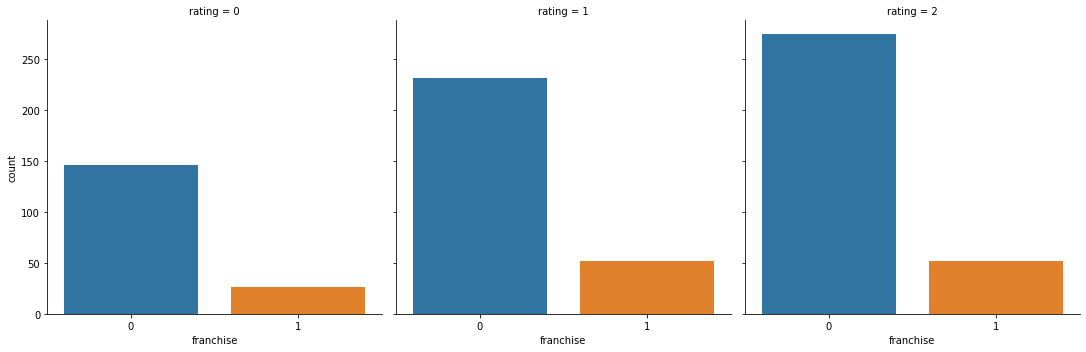

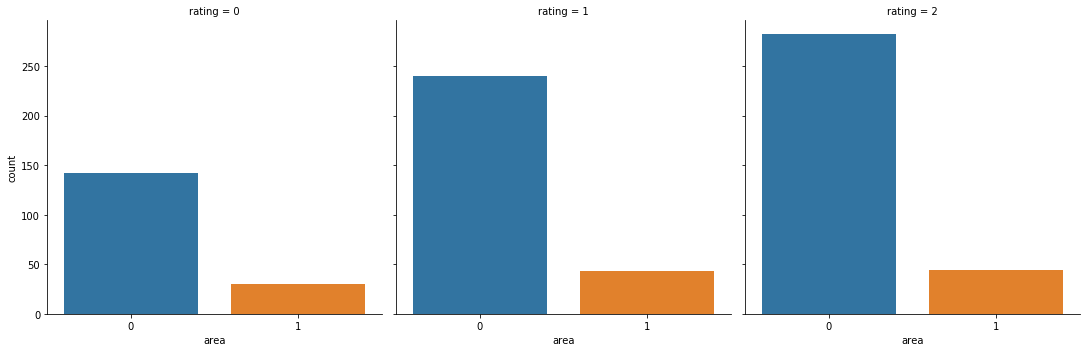

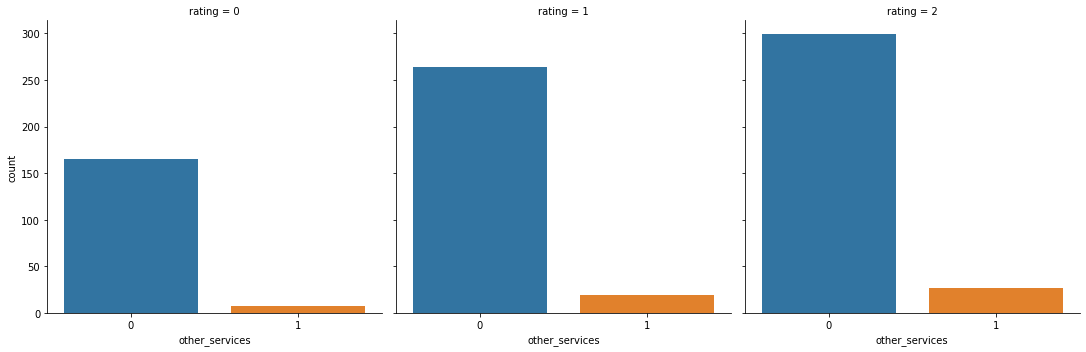

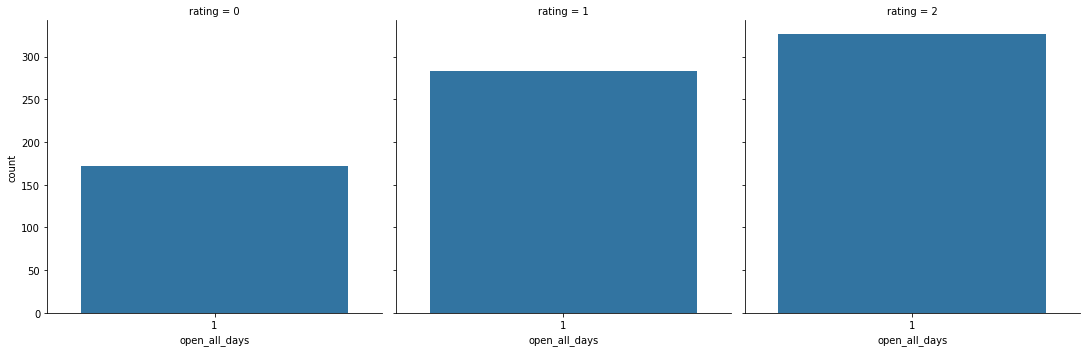

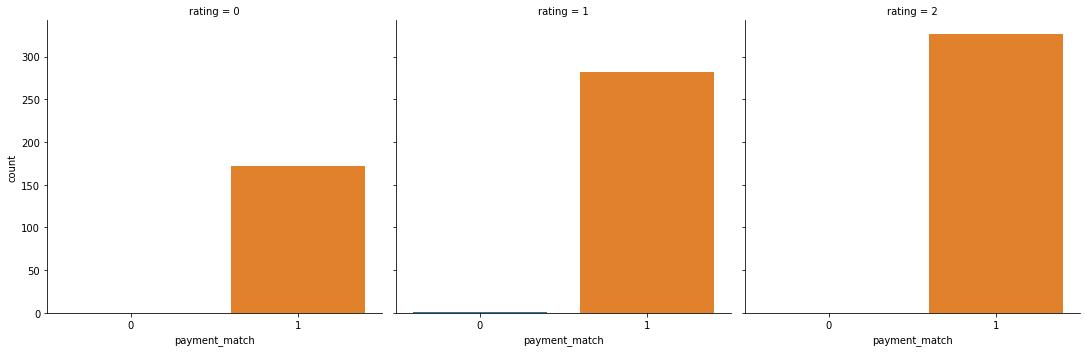

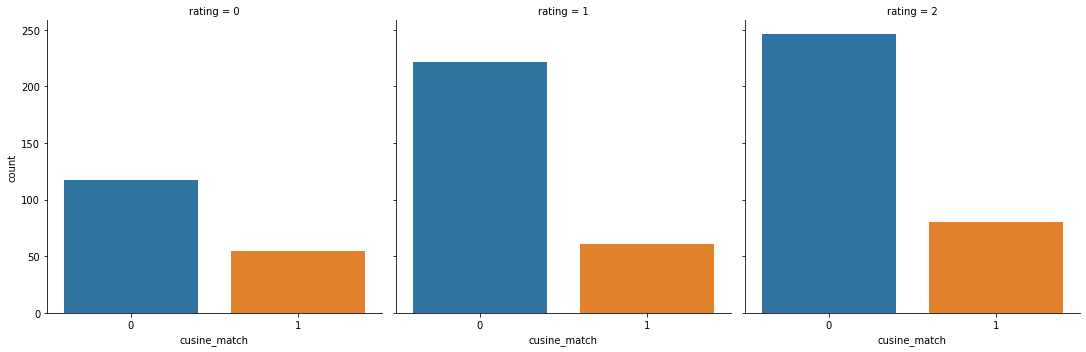

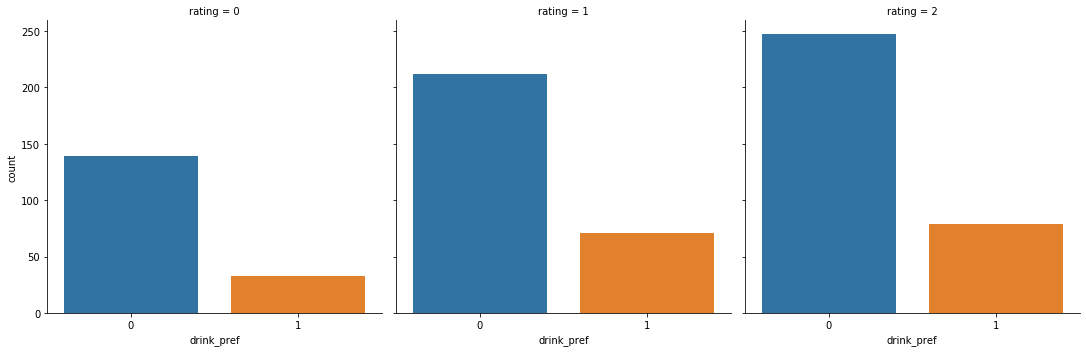

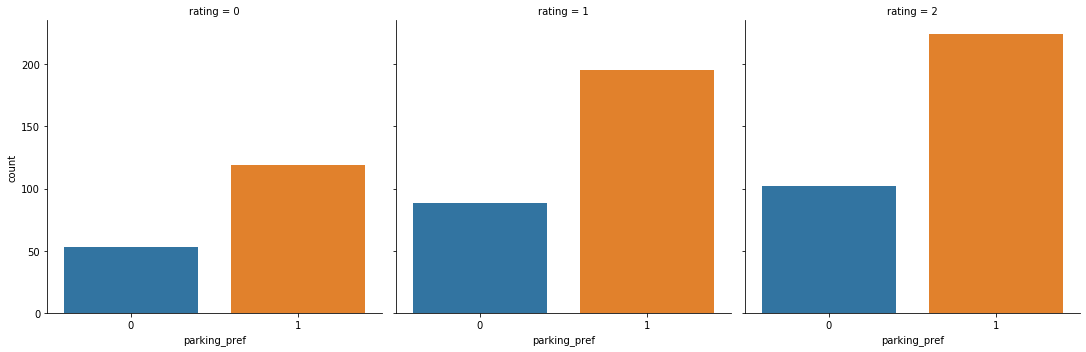

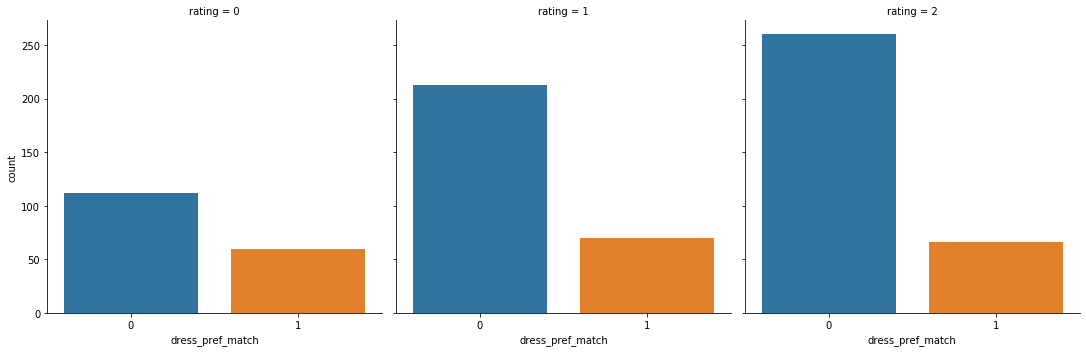

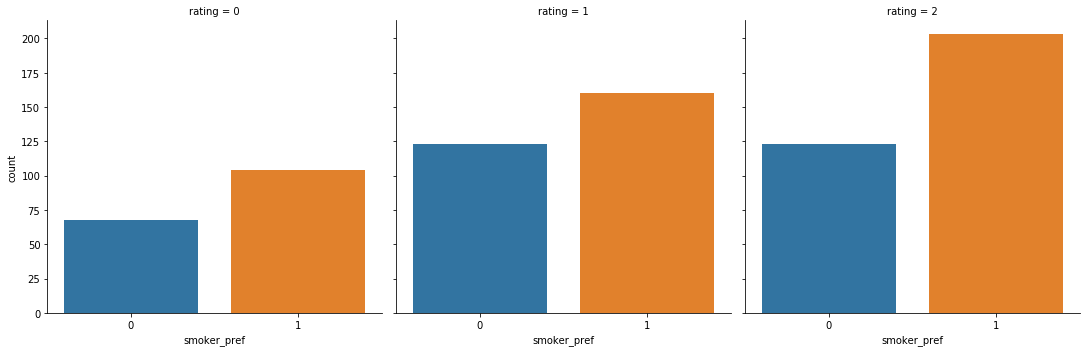

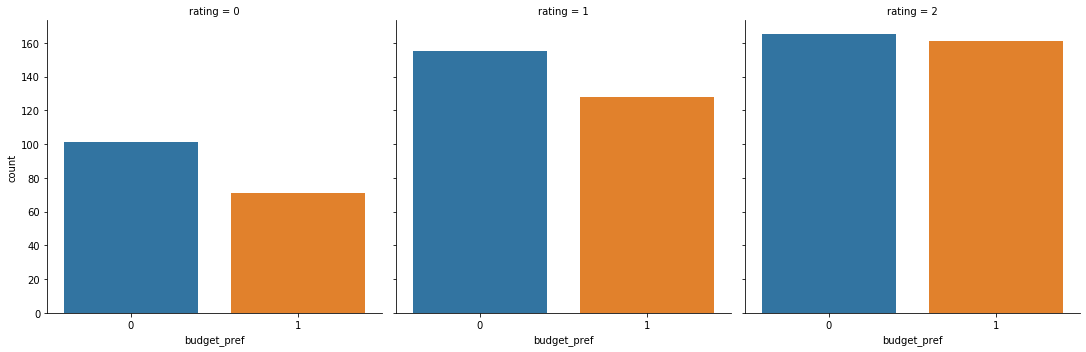

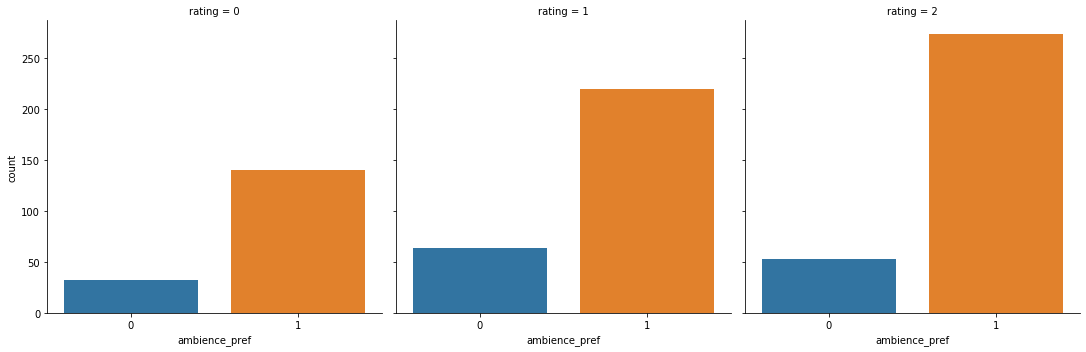

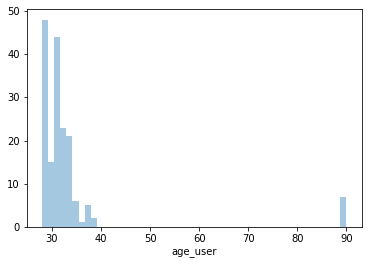

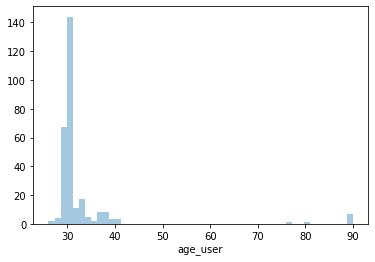

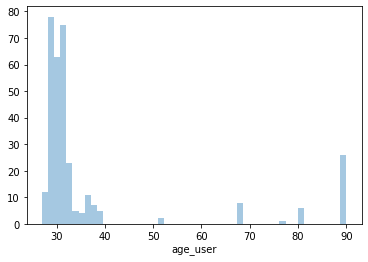

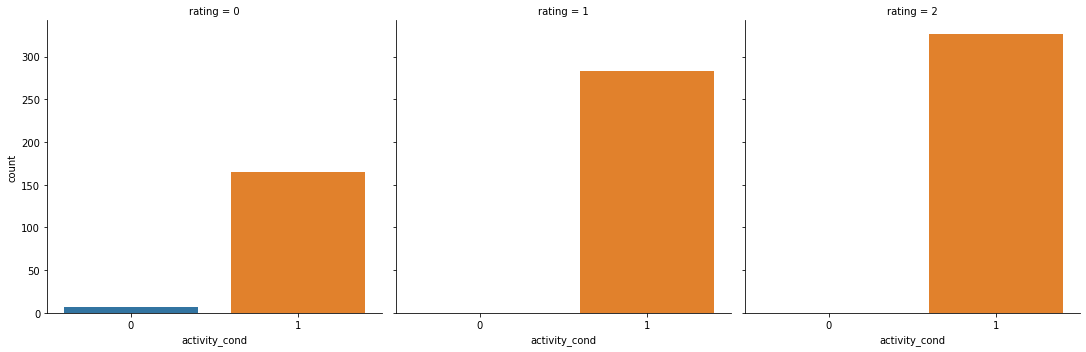

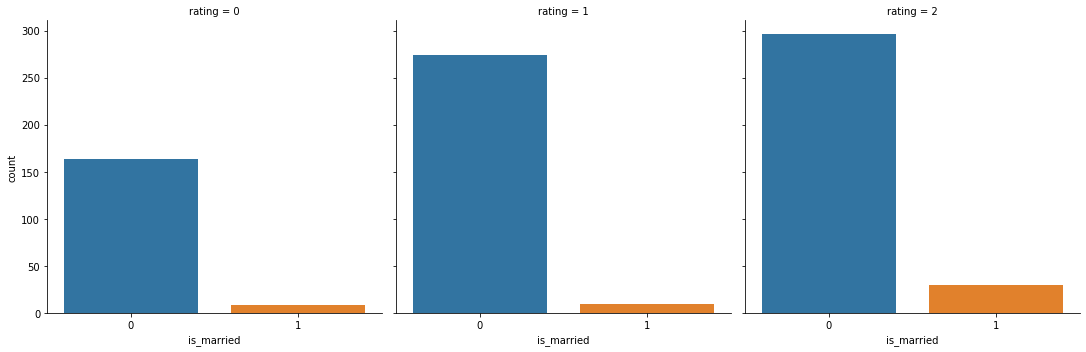

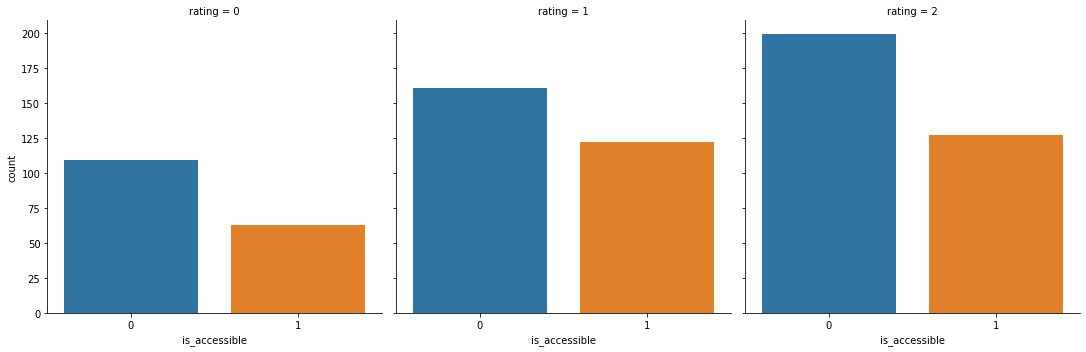

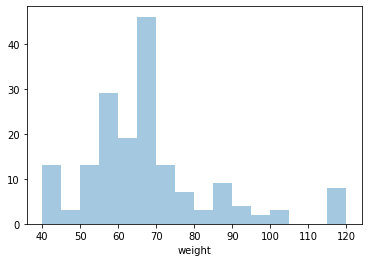

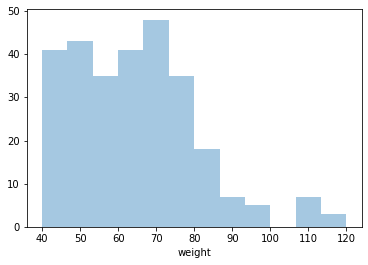

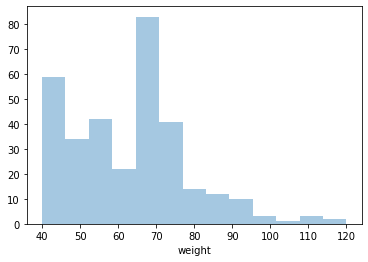

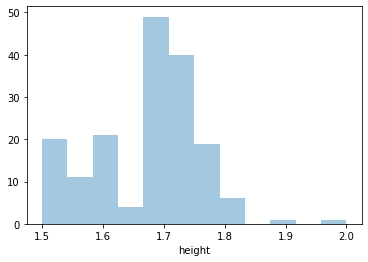

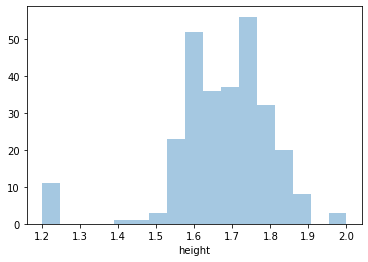

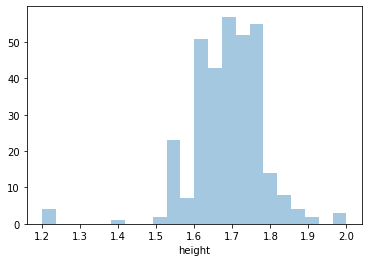

In [147]:
for i in ratings_res_user_oh.columns[:-1]:
    if i not in ['age_user','weight','height']:
        sns.catplot(x = i, data = ratings_res_user_oh, col = ratings_res_user_oh.columns[-1], kind = 'count')
        plt.show()
    else:
        sns.distplot(ratings_res_user_oh.loc[ratings_res_user_oh[ratings_res_user.columns[2]] == 0,i], kde = False)
        plt.show()
        sns.distplot(ratings_res_user_oh.loc[ratings_res_user_oh[ratings_res_user.columns[2]] == 1,i], kde = False)
        plt.show()
        sns.distplot(ratings_res_user_oh.loc[ratings_res_user_oh[ratings_res_user.columns[2]] == 2,i], kde = False)
        plt.show()

# Setting up scaler instance

In [148]:
mmx = MinMaxScaler()

In [149]:
mmx.fit(ratings_res_user_oh.age_user.values.reshape(-1,1))

MinMaxScaler()

# Scaling user age so that the values are between -1 and 1 and they are in scale with other selected features

In [150]:
ratings_res_user_oh.age_user = mmx.transform(ratings_res_user_oh.age_user.values.reshape(-1,1))
ratings_res_user_oh.weight = mmx.transform(ratings_res_user_oh.weight.values.reshape(-1,1))
ratings_res_user_oh.height = mmx.transform(ratings_res_user_oh.height.values.reshape(-1,1))

# Splitting the dataframe into train and test

In [151]:
X = ratings_res_user_oh.iloc[:,:-1]
y = ratings_res_user_oh.iloc[:,-1]

In [152]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)

# Setting up SMOTE instance to understand how the model performs given a balanced dataset

In [153]:
smt = SMOTE(sampling_strategy='all')

In [154]:
X_train_smt, y_train_smt = smt.fit_resample(X_train,y_train)

# Setting up instance for Logistic Regression. Setting class weight to balanced so that equal weughts are given to all classes with non uniform class frequencies. Since more than one class is there hence selecting multinomial logistic regression

In [155]:
logReg = LogisticRegression(class_weight='balanced', multi_class='multinomial', max_iter=1000)

In [156]:
logReg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')

# Here we are checking for precision as we want our model to correctly classify each class correctly rather than having a lot of false positives. The precision here are not that great due to insufficient examples per class. We need to train the model with more data and perform Hyper parameter tuning as well.

In [157]:
print(metrics.classification_report(y_test, logReg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.23      0.26      0.24        43
           1       0.44      0.51      0.47        71
           2       0.42      0.34      0.38        82

    accuracy                           0.38       196
   macro avg       0.36      0.37      0.36       196
weighted avg       0.39      0.38      0.38       196



# Even with data for equal class distribution, the model performace doesn't increase much

In [158]:
logReg.fit(X_train_smt, y_train_smt)

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')

In [159]:
print(metrics.classification_report(y_test, logReg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.28      0.40      0.33        43
           1       0.41      0.45      0.43        71
           2       0.46      0.32      0.38        82

    accuracy                           0.38       196
   macro avg       0.38      0.39      0.38       196
weighted avg       0.40      0.38      0.38       196



# Setting up the random forest instance

In [160]:
rfc = RandomForestClassifier()

In [161]:
rfc.fit(X_train, y_train)

RandomForestClassifier()

# Here we are checking for precision as we want our model to correctly classify each class correctly rather than having a lot of false positives. The precision here are not that great due to insufficient examples per class. We need to train the model with more data and perform Hyper parameter tuning as well.

In [162]:
print(metrics.classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.39      0.30      0.34        43
           1       0.46      0.51      0.48        71
           2       0.53      0.55      0.54        82

    accuracy                           0.48       196
   macro avg       0.46      0.45      0.45       196
weighted avg       0.48      0.48      0.48       196



# Even with data for equal class distribution, the model performace doesn't increase much

In [163]:
rfc.fit(X_train_smt, y_train_smt)
print(metrics.classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.44      0.40      0.41        43
           1       0.47      0.54      0.50        71
           2       0.55      0.51      0.53        82

    accuracy                           0.49       196
   macro avg       0.49      0.48      0.48       196
weighted avg       0.50      0.49      0.49       196



# Simulating some test cases

# Worst case when all the features are 0

In [166]:
ratings_res_user_oh.head(1)

,franchise,area,other_services,open_all_days,payment_match,cusine_match,drink_pref,parking_pref,dress_pref_match,smoker_pref,budget_pref,ambience_pref,age_user,activity_cond,is_married,is_accessible,weight,height,rating
0,0,0,0,1,1,0,0,1,0,1,1,1,0.109375,1,1,0,0.609375,-0.379531,2


In [167]:
test_case_1 = {'franchise':[0],'area':[0], 'other_services':[0], 'open_all_days':[0],'payment_match':[0],'cusine_match':[0],'drink_pref':[0],'parking_pref':[0], 'dress_pref_match':[0],'smoker_pred':[0],'budget_pref':[0],'ambience_pref':[0],'age_user':list(mmx.transform([[40]]))[0],'activity_cond':[0], 'is_married':[0],'is_accessible':[0], 'weight':list(mmx.transform([[60]]))[0],'height':list(mmx.transform([[17]]))[0] }

In [168]:
test_case_1 = pd.DataFrame(test_case_1)

In [169]:
test_case_1

,franchise,area,other_services,open_all_days,payment_match,cusine_match,drink_pref,parking_pref,dress_pref_match,smoker_pred,budget_pref,ambience_pref,age_user,activity_cond,is_married,is_accessible,weight,height
0,0,0,0,0,0,0,0,0,0,0,0,0,0.21875,0,0,0,0.53125,-0.140625


In [170]:
print(f'{ratings.columns[-1]}: {logReg.predict(test_case_1)[0]}')

rating: 0


# Best Case when all the features are 1

In [171]:
test_case_2 = {'franchise':[1],'area':[1], 'other_services':[1], 'open_all_days':[1],'payment_match':[1],'cusine_match':[1],'drink_pref':[1],'parking_pref':[1], 'dress_pref_match':[1],'smoker_pred':[1],'budget_pref':[1],'ambience_pref':[1],'age_user':list(mmx.transform([[40]]))[0],'activity_cond':[1], 'is_married':[1],'is_accessible':[1], 'weight':list(mmx.transform([[60]]))[0],'height':list(mmx.transform([[17]]))[0]}

In [172]:
test_case_2 = pd.DataFrame(test_case_2)

In [173]:
print(f'{ratings.columns[-1]}: {logReg.predict(test_case_2)[0]}')

rating: 2


# Simulating Random Cases [Run Multiple Times to get different outputs]

In [184]:
test_case_random = {'franchise':[np.random.randint(0,2)],'area':[np.random.randint(0,2)], 'other_services':[np.random.randint(0,2)], 'open_all_days':[np.random.randint(0,2)],'payment_match':[np.random.randint(0,2)],'cusine_match':[np.random.randint(0,2)],'drink_pref':[np.random.randint(0,2)],'parking_pref':[np.random.randint(0,2)], 'dress_pref_match':[np.random.randint(0,2)],'smoker_pred':[np.random.randint(0,2)],'budget_pref':[np.random.randint(0,2)],'ambience_pref':[np.random.randint(0,2)],'age_user':list(mmx.transform([[np.random.randint(26,100)]]))[0],'activity_cond':[np.random.randint(0,2)], 'is_married':[np.random.randint(0,2)],'is_accessible':[np.random.randint(0,2)], 'weight':list(mmx.transform([[np.random.randint(40,130)]]))[0],'height':list(mmx.transform([[np.random.randint(1,3)]]))[0]}

In [185]:
test_case_random = pd.DataFrame(test_case_random)
test_case_random

,franchise,area,other_services,open_all_days,payment_match,cusine_match,drink_pref,parking_pref,dress_pref_match,smoker_pred,budget_pref,ambience_pref,age_user,activity_cond,is_married,is_accessible,weight,height
0,1,0,0,1,0,0,1,1,1,0,0,1,0.15625,0,1,1,0.578125,-0.375


In [186]:
print(f'{ratings.columns[-1]}: {logReg.predict(test_case_random)[0]}')

rating: 0


# Improvement Approaches:
    1. Hyper parameter tuning of statistical models.
    2. Deep Neural Network Classification with Drop out regulazation and hyper parameter tuning (provided we get more data).
    3. Collect more data for each class.
    4. More feature engineering.
    5. Since data is very less, a rule based filtering approach can also be used to predict the ratings in a crude way.

# END OF FILE